- $W$: matrix of (thresholded) weights
- $\gamma$: decay parameter

NMPH function
$$
\text{NMPH}(x) = \begin{cases}
2 x \cdot y_{min}/x_{cp} & x \leq x_{\text{cp}/2}\\
2 x \cdot (y_{cp} - y_{min})/x_{cp} & x_{\text{cp}/2} < x \leq x_{\text{cp}}\\
x \cdot (y_{max} - y_{cp})/(1 - x_{\text{cp}}) & x_{\text{cp}} < x \leq 1
\end{cases}
$$

Weight update
$$W^{t+1}_{k-1,k} = \Delta_{k-1,k}W^t_{k-1, k}$$

Sigmoid
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Let $W_0, \text{ACT}_0$ be the initial conditions

$$
\text{ACT}_k = \sigma\left(\sum_{i=1}^{k}\gamma^i\prod_{d=1}^{i}\sigma\left(W_{d-1} + \text{NMPH}(\text{ACT}_{d-1})\right)\right)\\
$$

$$
\Delta W_d = \sigma\left(W_{d-1} + \text{NMPH}(\text{ACT}_{d-1})\right)
$$

$$
\text{ACT}_k = \sigma\left(\sum_{i=1}^{k}\gamma^i\prod_{d=1}^{i}\Delta W_d\right)\\
$$

In [19]:
import sys
sys.path.insert(1, '../')
from graphsemnet.gsn import compute_nmph, simulate_distance_matrix, normalize_distance_matrix
from scipy.special import expit
import numpy as np

In [687]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [20]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
W = simulate_distance_matrix(100, 10, 10)

In [22]:
W -= W.min()
W /= (W.max() - W.min())

In [23]:
W[np.tril_indices_from(W)] = 0.

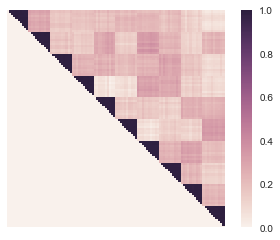

In [24]:
sns.heatmap(W, xticklabels=False, yticklabels=False, square=True)

In [25]:
n_nodes = len(W)

In [26]:
nmph = compute_nmph(-0.4, 0.5, 0.5, 0.6)

In [27]:
x = np.linspace(0, 1, 100)
y = nmph(x)

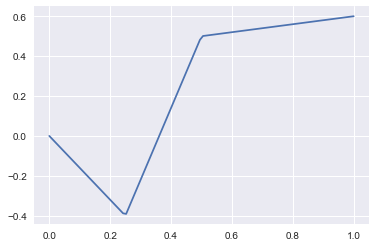

In [28]:
plt.plot(x, y)

In [233]:
def my_expit(x, mult=10, mu=0.5):
    return expit((x-mu)*mult)

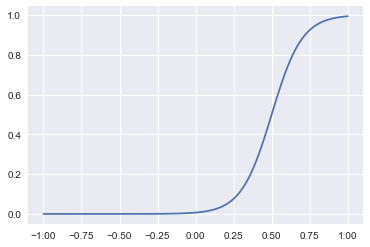

In [234]:
x = np.linspace(-1, 1, 100)
plt.plot(x, my_expit(x))

In [235]:
gamma = 0.1

In [236]:
from numpy.linalg import multi_dot

In [237]:
W_thresh = W.copy()
W_thresh[W_thresh <= 0.3] = 0.

$$
W_d = \sigma\left(W_{d-1} + A\circ h(\text{ACT}_{d-1})\right)
$$

$$
\text{ACT}_k =  \sigma\left(\mathbf{1}\cdot\sum_{i=0}^{k-1}\gamma^i\text{ACT}_{i}\circ\prod_{d=0}^{i}W_d\right) \\
$$

$\circ$ and $\Pi$ denote element-wise multiplication

$\cdot$ denotes dot-product

$\text{ACT}_i$ is a column vector

$\mathbf{1} = [1, 1, ..., 1]$, a row vector of ones

In [425]:
def mdot(list_array):
    """Multi dot product; if len(list_array) == 1, returns list_array[0]"""
    if len(list_array) == 1:
        return list_array[0]
    else:
        return multi_dot(list_array)

In [426]:
from numpy.linalg import multi_dot

In [639]:
def spread_activation(W0, ACT0, nmph, gamma, d, A):
    """Spread activation with NMPH on a graph with initial weight W0, and activation ACT0
    
    Arguments
    ---------
    W0 : array (n_nodes, n_nodes)
        initial weights of the graph
    ACT0 : array (n_nodes, 1)
        column array of initial activations
    npmh : function [0, 1] -> [-1, 1]
        nmph function, generated with `compute_nmph
    gamma : float [0, 1]
        decay parameter
    d : int
        how far the activation is allowed to spread
    
    Returns
    -------
    Ws : list of arrays (n_nodes, n_nodes)
    ACT : list of arrays 
        activations for every depth
    """
    # initialize values
    assert(ACT0.shape[0] >= ACT0.shape[1])
    Ws = [W0]
    ACT = [ACT0]
    dW = np.zeros(ACT0.shape)

    # loop 
    for i in range(d):
        # update W
        W_i = my_expit(Ws[-1] + A*nmph(ACT[-1]))
        Ws.append(W_i)
        # update ACT
        dW += ((gamma**i) * np.multiply.reduce(Ws) * ACT[i]).sum(axis=0)[:, None]
        ACT_ = my_expit(dW)
        ACT.append(ACT_)
    return Ws, ACT

In [628]:
def myheatmap(W, yticklabels=None):
    return sns.heatmap(W, xticklabels=False, yticklabels=yticklabels, cbar=True, square=True) 

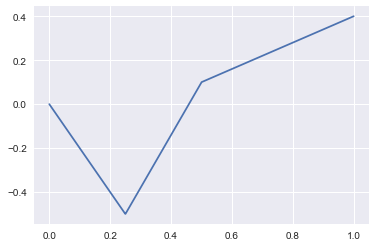

In [537]:
nmph = compute_nmph(-0.5, .5, .1, .4)
x = np.linspace(0, 1, 1000)
y = nmph(x)
plt.plot(x, y);

In [538]:
W = np.zeros((6, 6))
W[0, 1] = 0.55
W[0, 2] = 0.45
# W[1, 0] = 0.5
# W[2, 0] = 0.5


W[3, 4] = 0.5
W[3, 5] = 0.5

In [539]:
A = W.copy()
A[A > 0] = 1.

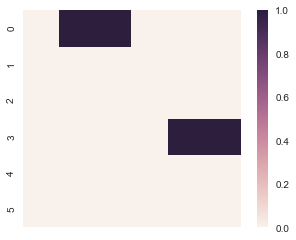

In [540]:
myheatmap(A);

In [556]:
ACT0 = np.zeros((1, 6))
ACT0[0][0] = 1.

In [557]:
ACT0

array([[ 1.,  0.,  0.,  0.,  0.,  0.]])

In [558]:
Ws, ACT = spread_activation(W, ACT0, nmph, gamma, 3, A)

In [559]:
ACT

[array([[ 1.,  0.,  0.,  0.,  0.,  0.]]),
 array([[ 0.00669285,  0.17129548,  0.0355346 ,  0.00669285,  0.00669285,
          0.00669285]]),
 array([[ 0.00669285,  0.17139272,  0.03554936,  0.00669285,  0.00670844,
          0.00670844]]),
 array([[ 0.00669285,  0.17139273,  0.03554941,  0.00669285,  0.00671024,
          0.00671024]])]

In [554]:
ACT[1].shape

(1, 6)

In [610]:
winner_r = []
winner_nr = []
ACT0 = np.zeros((1, 6))
for i in range(1000):
    W_ = W.copy()
    W_ += np.random.randn(*W_.shape)/10
    ACT0_r = ACT0.copy()
    ACT0_r[0][0] = 1.
    ACT0_nr = ACT0.copy()
    ACT0_nr[0][3] = 1.
    Ws, ACT = spread_activation(W_, ACT0_r, nmph, gamma, 1, A)
    
    check_id = np.where(ACT0_r)[0]
    winner_r.append(np.argmax(ACT[-1][check_id]))
    
    Ws, ACT = spread_activation(W_, ACT0_nr, nmph, gamma, 1, A)
    
    check_id = np.where(ACT0_nr)[0]
    winner_nr.append(np.argmax(ACT[-1][check_id]))

In [611]:
ACT

[array([[ 0.,  0.,  0.,  1.,  0.,  0.]]),
 array([[ 0.00667773,  0.00702212,  0.00703236,  0.0066925 ,  0.48866978,
          0.47959576]])]

In [571]:
p_r = np.sum(np.array(winner_r) == 1)
p_nr = np.sum(np.array(winner_nr) == 4)

In [573]:
print(p_nr), print(p_r)

501
769


(None, None)

In [624]:
W = np.zeros((6, 6))
W[0, 1] = 0.5
W[0, 2] = 0.5

W[3, 4] = 0.5
W[3, 5] = 0.5

W += W.T

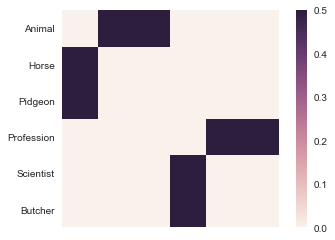

In [632]:
myheatmap(W, yticklabels=['Animal', 'Horse', 'Pidgeon', 'Profession', 'Scientist', 'Butcher']);

In [773]:
gamma = 0.3
depth = 3
n_iter = 10000

In [774]:
winner_iter = []

for i in range(n_iter):
    # Phase 1: Study
    W = np.zeros((6, 6))
    W[0, 1] = 0.5
    W[0, 2] = 0.5

    W[3, 4] = 0.5
    W[3, 5] = 0.5
    W += W.T

    # Add noise
    W += np.abs(np.random.randn(*W.shape)/10)
    # adjacency please
    A = compute_adjacency(W)

    # Phase 2: Retrieval Practice
    # We want horse
    ACT_pr = np.array([1, .25, 0, 0, 0, 0])[:, None] # we want a column vector
    W_ = W
    for _ in range(1):
        Ws, ACT = spread_activation(W_, ACT_pr, nmph, gamma, depth, A)
        W_ = Ws[-1]

    # Phase 3: Test
    W_te = Ws[-1]
    ACT_rpplus = np.array([1, .1, 0, 0, 0, 0])[:, None]
    ACT_rpminus = np.array([1, 0, .1, 0, 0, 0])[:, None]
    ACT_nrp1 = np.array([0, 0, 0, 1, .1, 0])[:, None]
    ACT_nrp2 = np.array([0, 0, 0, 1, 0, .1])[:, None]
    
    winners = []
    for activation, which in zip([ACT_rpplus, ACT_rpminus, ACT_nrp1, ACT_nrp2], [1, 2, 4, 5]):
        _, activation_ = spread_activation(W_te, activation, nmph, gamma, depth, A)
        activation_[-1][0] = 0.
        activation_[-1][3] = 0.
        winners.append(np.argmax(activation_[-1]).astype(int))
        #winners.append((activation_[-1][which] > 0.5).astype(int))
    winner_iter.append(winners)

winner_iter = np.array(winner_iter)

rpplus = np.sum(winner_iter[:, 0] == 1)/n_iter
rpminus = np.sum(winner_iter[:, 1] == 2)/n_iter
nrp = (np.sum(winner_iter[:, 2] == 4)/n_iter + np.sum(winner_iter[:, 3] == 5)/n_iter)/2.

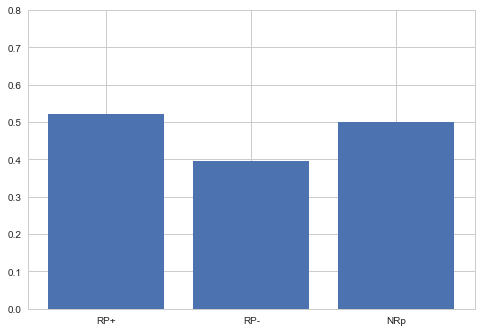

In [775]:
fig, ax = plt.subplots(1, 1)
ax.bar([0, 1, 2], [rpplus, rpminus, nrp], tick_label=['RP+', 'RP-', 'NRp'])
ax.set_ylim([0, .8]);

In [617]:
,print(ACT)

[array([[ 0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 0.00669285,  0.00669285,  0.00669285,  0.00669285,  0.00669285,
         0.00669285]]), array([[ 0.00672406,  0.00670844,  0.00670844,  0.00672406,  0.00670844,
         0.00670844]]), array([[ 0.00672769,  0.00671025,  0.00671025,  0.00672769,  0.00671025,
         0.00671025]])]


(array([ 501.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  499.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

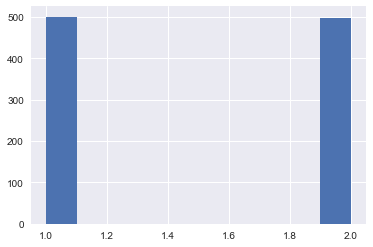

In [618]:
plt.hist(winner)

In [619]:
print(Ws[-1])

[[ 0.00718555  0.38494173  0.38494173  0.00718555  0.00718555  0.00718555]
 [ 0.38501572  0.00718555  0.00718555  0.00718555  0.00718555  0.00718555]
 [ 0.38501572  0.00718555  0.00718555  0.00718555  0.00718555  0.00718555]
 [ 0.00718555  0.00718555  0.00718555  0.00718555  0.38494173  0.38494173]
 [ 0.00718555  0.00718555  0.00718555  0.38501572  0.00718555  0.00718555]
 [ 0.00718555  0.00718555  0.00718555  0.38501572  0.00718555  0.00718555]]


In [576]:
def compute_adjacency(W):
    A = W.copy()
    A[A > 0.] = 1.
    return A

In [577]:
A = compute_adjacency(W)

In [582]:
ACT_ = ACT0.copy()
ACT_[0][1] = 1.

In [587]:
print(W)

[[ 0.   0.5  0.5  0.   0.   0. ]
 [ 0.5  0.   0.   0.   0.   0. ]
 [ 0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5  0.5]
 [ 0.   0.   0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.5  0.   0. ]]


In [588]:
Ws, ACT = spread_activation(W, ACT_, nmph, 0.3, 3, A)

In [589]:
print(Ws[-1])

[[ 0.00718555  0.99150058  0.38424307  0.00718555  0.00718555  0.00718555]
 [ 0.00882851  0.00718555  0.00718555  0.00718555  0.00718555  0.00718555]
 [ 0.00882851  0.00718555  0.00718555  0.00718555  0.00718555  0.00718555]
 [ 0.00718555  0.00718555  0.00718555  0.00718555  0.38501572  0.38501572]
 [ 0.00718555  0.00718555  0.00718555  0.38494173  0.00718555  0.00718555]
 [ 0.00718555  0.00718555  0.00718555  0.38494173  0.00718555  0.00718555]]


In [585]:
print(ACT[-1])

[[ 0.07598523  0.00771923  0.00689261  0.00672769  0.00671025  0.00671025]]


In [529]:
ACT_ = ACT0.copy()
ACT_[0] = 1.

In [531]:
Wss, ACT = spread_activation(Ws[-1], ACT_, nmph, 0.3, 3, A)

In [533]:
print(Wss[-1])

[[ 0.00718806  0.98827469  0.98827469  0.00718806  0.00718806  0.00718806]
 [ 0.99169769  0.00718806  0.00718806  0.00718806  0.00718806  0.00718806]
 [ 0.01076857  0.00718806  0.00718806  0.00718806  0.00718806  0.00718806]
 [ 0.00718806  0.00718806  0.00718806  0.00718806  0.01076857  0.01076857]
 [ 0.00718806  0.00718806  0.00718806  0.01076857  0.00718806  0.00718806]
 [ 0.00718806  0.00718806  0.00718806  0.01076857  0.00718806  0.00718806]]


In [535]:
print(ACT[-1])

[[ 0.00669388  0.01984627  0.01984627  0.00669388  0.00669388  0.00669388]
 [ 0.00674355  0.00669285  0.00669285  0.00669285  0.00669285  0.00669285]
 [ 0.00669308  0.00669285  0.00669285  0.00669285  0.00669285  0.00669285]
 [ 0.00669285  0.00669285  0.00669285  0.00669285  0.00669308  0.00669308]
 [ 0.00669285  0.00669285  0.00669285  0.00669308  0.00669285  0.00669285]
 [ 0.00669285  0.00669285  0.00669285  0.00669308  0.00669285  0.00669285]]
